In [ ]:
#import the necessary packages
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Flatten, Dropout, Dense
from google.colab.patches import cv2_imshow

Define CNN architecture

In [ ]:
class SimpleCNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # first CONV => RELU => BN layer set
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # second CONV => RELU => BN layer set
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

Define PGD architecture

In [ ]:
# [dataset_type] 0:cifar10, 1:cifar100
# [model_type] 0:DNN, 1:CNN
class PGD():
  def __init__(self, dataset_type=0, model_type=1, name='abc', alpha=0.1):
    self.dataset_type = dataset_type
    self.model_type = model_type
    # CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck:
    self.labels_cifar10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    self.name = name
    self.alpha = alpha
    self.Initialize()

  def Initialize(self):
    self.load_dataset()
    self.data_preprocessing()
    self.build_model()

  def load_dataset(self):
    if self.dataset_type == 0:
      print("[INFO] loading CIFAR-10 dataset...")
      (self.trainX, self.trainY), (self.testX, self.testY) = cifar10.load_data()

  def data_preprocessing(self):
    self.trainX = self.trainX / 255.0
    self.testX = self.testX / 255.0
    # add a channel dimension to the images
    self.trainX = np.expand_dims(self.trainX, axis=-1)
    self.testX = np.expand_dims(self.testX, axis=-1)
    # one-hot encode our labels
    self.trainY = to_categorical(self.trainY, 10)
    self.testY = to_categorical(self.testY, 10)

  def build_model(self):
    if self.dataset_type == 0:
      self.model = SimpleCNN.build(width=32, height=32, depth=3, classes=10) # define our model

    print("[INFO] compiling model...")
    self.opt = Adam(learning_rate=1e-3) # initial learning rate

    # prepare model for fitting (loss, optimizer, metrics)
    self.model.compile(loss='categorical_crossentropy', # we train 10-way classification
                       optimizer='adam',
                       metrics=['accuracy']) # report accuracy during training

  def train_evaluate_model(self, epochs=10, batch_size=64):
      print("[INFO] training network...")
      # fit model
      self.model.fit(self.trainX, self.trainY, # prepared data
                     validation_data=(self.testX, self.testY),batch_size=batch_size, epochs=epochs, verbose=1)

      # evaluate model
      print("[INFO] evaluating network...")
      (loss, acc) = self.model.evaluate(x=self.testX, y=self.testY, verbose=0)
      print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

  def generate_image_adversary(self, image, label, alpha=0.01 / 255.0):
        # convert the image to a TensorFlow tensor
        image = tf.cast(image, tf.float32)

        # generate the adversarial example
        # record our gradients
        with tf.GradientTape() as tape:
            # explicitly indicate that our image should be tracked for gradient updates
            tape.watch(image) # track changes to the input image

            # use our model to make predictions on the input image and then compute the loss
            pred = self.model(image)
            loss = MSE(label, pred) # compute the mean squared error between the label and prediction
        gradient = tape.gradient(loss, image) # compute the gradient of the loss with respect to the input image
        signedGrad = tf.sign(gradient) # get the sign of the gradient (+/-)
        adversary = image + self.alpha * signedGrad # add the signed gradient to the original image

        # Clip the input to the valid range
        adversary = tf.clip_by_value(adversary, 0, 1)

        # return the image adversary to the calling function
        return adversary

  def generate_image_adversary_targeted(self, image, target, alpha=0.01 / 255.0):
        # convert the image to a TensorFlow tensor
        image = tf.cast(image, tf.float32)

        # generate the adversarial example
        # record our gradients
        with tf.GradientTape() as tape:
            # explicitly indicate that our image should be tracked for gradient updates
            tape.watch(image) # track changes to the input image

            target = target.reshape(1, 10)

            # use our model to make predictions on the input image and then compute the loss
            pred = self.model(image)
            # use categorical_crossentropy as a loss function for multi-class classification model where there are two or more output labels
            loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True) # the output values generated by the model are not normalized
            loss = loss_func(target, pred)

        gradient = tape.gradient(loss, image) # compute the gradient of the loss with respect to the input image
        signedGrad = tf.sign(gradient) # get the sign of the gradient (+/-)
        adversary = image - self.alpha * signedGrad # subtract the signed gradient to the original image

        # Clip the input to the valid range
        adversary = tf.clip_by_value(adversary, 0, 1)

        # return the image adversary to the calling function
        return adversary

  def my_generator(self,
                   max_iterations=30, targeted=False, target=None): # set the maximum number of iterations to prevent infinite repetitions

        # loop over a sample of our testing images
        for i in np.random.choice(np.arange(0, len(self.testX)), size=(10,)):
            # grab the image and label
            image = self.testX[i]
            label = self.testY[i]
            adversary = image.reshape(1, 32, 32, 3)
            iteration = 0

            if targeted:
                if target is None:
                    raise ValueError("target must be provided for a targeted attack.")
                target = to_categorical([target], num_classes=10)
                target = tf.convert_to_tensor(target, dtype=tf.float32)

            while iteration < max_iterations:
                # generate the adversarial example
                if targeted:
                    adversary = self.generate_image_adversary_targeted(adversary, target, alpha=0.1)
                else:
                    adversary = self.generate_image_adversary(adversary, label, alpha=0.1)

                pred = self.model.predict(adversary) # predict the label of the adversarial example
                adversaryPred = pred[0].argmax()

                 # if the prediction is correct (non-targeted) or matches the target label (targeted), break the loop
                if (not targeted and adversaryPred != label.argmax()) or (targeted and adversaryPred == target):
                    break

                # otherwise, increment the iteration
                iteration += 1

            # scale both the original image and adversary to the range [0, 255]
            adversary = adversary.numpy().reshape((32, 32, 3)) * 255
            adversary = np.clip(adversary, 0, 255).astype("uint8")
            image = image.reshape((32, 32, 3)) * 255
            image = image.astype("uint8") # convert to an unsigned 8-bit integers

            # convert the image and adversarial image from grayscale to three channel

            # resize the images so we can better visualize them
            image = cv2.resize(image, (96, 96))
            adversary = cv2.resize(adversary, (96, 96))

            # determine the predicted label for both the original image and adversarial image

            # get the index of the class with the highest probability
            imagePred = label.argmax()
            adversaryPred = pred[0].argmax()
            color = (0, 255, 0) # green
            if imagePred != adversaryPred: # if the prediction is incorrect, set the color to red
               color = (0, 0, 255)

            # draw the predictions on the respective output images
            cv2.putText(image, str(imagePred), (2, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
            cv2.putText(adversary, str(adversaryPred), (2, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

            # stack the two images horizontally and then show the original image and adversarial image
            output = np.hstack([image, adversary])
            cv2_imshow(output) # imports the function cv2_imshow instead of cv2.imshow in Google Colab
            cv2.waitKey(0)

  def run(self):
        self.build_model
        self.train_evaluate_model()
        self.my_generator()

Generate adversarial examples by calling PGD

[INFO] loading CIFAR-10 dataset...
170498071/170498071 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] loading CIFAR-10 dataset...
[INFO] compiling model...
[INFO] training network...
Epoch 1/10
782/782 [==============================] - 39s 47ms/step - loss: 1.6665 - accuracy: 0.4365 - val_loss: 1.2605 - val_accuracy: 0.5507
Epoch 2/10
782/782 [==============================] - 33s 43ms/step - loss: 1.2019 - accuracy: 0.5750 - val_loss: 1.3229 - val_accuracy: 0.5311
Epoch 3/10
782/782 [==============================] - 35s 44ms/step - loss: 1.0456 - accuracy: 0.6314 - val_loss: 1.0718 - val_accuracy: 0.6260
Epoch 4/10
782/782 [==============================] - 34s 44ms/step - loss: 0.9501 - accuracy: 0.6659 - val_loss: 1.0390 - val_accuracy: 0.6344
Epoch 5/10
782/782 [==============================] - 34s 43ms/step - loss: 0.8685 - accuracy: 0.6935 - val_loss: 1.0223 - val_accuracy: 0.6408
Epoch 6/10
782/782 [==============================] - 35s 44ms/s

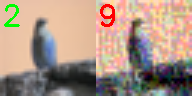

1/1 [==============================] - 0s 37ms/step


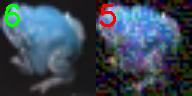

1/1 [==============================] - 0s 31ms/step


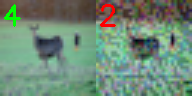

1/1 [==============================] - 0s 34ms/step


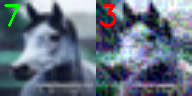

1/1 [==============================] - 0s 30ms/step


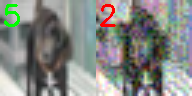

1/1 [==============================] - 0s 30ms/step


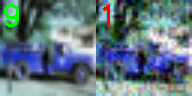

1/1 [==============================] - 0s 30ms/step


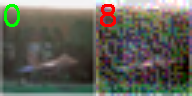

1/1 [==============================] - 0s 29ms/step


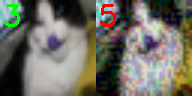

1/1 [==============================] - 0s 29ms/step


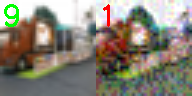

1/1 [==============================] - 0s 31ms/step


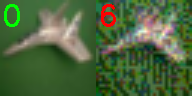

In [ ]:
result = PGD(name='test')
result.Initialize()
result.run()